# Traversing and Analyzing Coronal Hole Connectivity Graph

In [1]:
import pickle
import networkx as nx
import os 
import copy
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib
import cv2
import datetime as dt
from analysis.ml_analysis.ch_tracking.tools.plots import plot_coronal_hole

plt.rcParams['savefig.facecolor']='white'
matplotlib.rcParams.update({'font.size': 12})

### Read in Coronal Hole Connectivity Graph 
Saved as a pickle file in DropBox. 

In [2]:
pickle_file = os.path.join(r"C:\Users\Opali\OneDrive\Desktop\CH_DB\connectivity_graph28.pkl")

In [3]:
graph = pickle.load(open(pickle_file, "rb"))


G = graph.G

### Analyze properties of the total graph

In [4]:
print("Total number of nodes: ", G.number_of_nodes())
print("Total number of edges: ", G.number_of_edges())
print("Total number of subplots: ", len(list(nx.connected_components(G))))

Total number of nodes:  8467
Total number of edges:  8742
Total number of subplots:  210


In [5]:
# order subgraphs based on average node area
subgraph_ordered = graph.order_subgraphs_based_on_area()

In [6]:
# save the total number of nodes in a subgraph
num_nodes_list = []
for ii, g in enumerate(subgraph_ordered):
    subgraph = G.subgraph(g)
    num_nodes_list.append(subgraph.number_of_nodes())

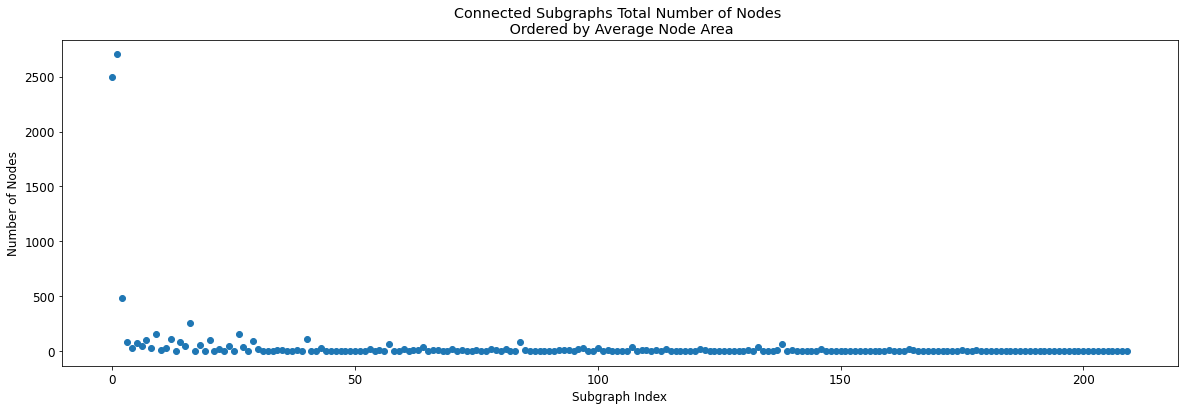

In [7]:
fig, ax = plt.subplots(figsize=(20, 6))
_ = ax.scatter(np.arange(len(num_nodes_list)), num_nodes_list)
_ = ax.set_ylabel("Number of Nodes")
_ = ax.set_xlabel("Subgraph Index")
_ = ax.set_title("Connected Subgraphs Total Number of Nodes \n Ordered by Average Node Area")

plt.savefig('figures/subgraph_node_size.png')

#### Note
From the plot above, it is visible that the graph has two main subgraphs. 
Assumption: one is connected to the north pole and the other to the south. Lets examine the first and second subgraph (with the largest umber of nodes $\approx$ 3000)

In [8]:
main_subgraph_1 = G.subgraph(subgraph_ordered[0])
main_subgraph_2 = G.subgraph(subgraph_ordered[1])

In [9]:
# list with all weights in G. 
w_list = [w["weight"] for u,v,w in G.edges.data()]

# analyze the weight between nodes that have the same id and nodes that have a different id. 
adj_diff_list = []
adj_same_list = []

# loop over all edges in G. 
for u,v,w in G.edges.data():
    # different id. 
    if G.nodes[u]["id"] != G.nodes[v]["id"]:
        adj_diff_list.append(w["weight"])
    # same id. 
    else:
        adj_same_list.append(w["weight"])

In [10]:
print("Number of edges between nodes of the same ID = ", len(adj_same_list))
print("Number of edges between nodes with different ID = ", len(adj_diff_list))

Number of edges between nodes of the same ID =  8172
Number of edges between nodes with different ID =  570


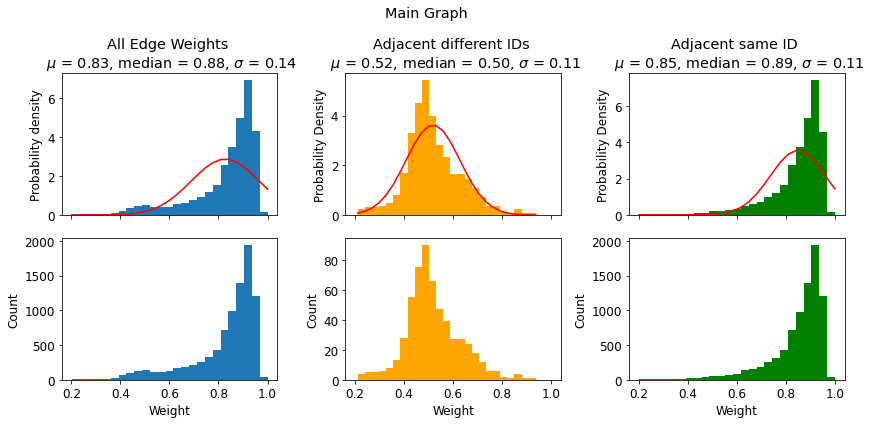

In [11]:
fig, ax = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(12, 6))
mu, sigma = scipy.stats.norm.fit(w_list)
n , bins, _ = ax[0][0].hist(w_list, 25, density=True)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0][0].plot(bins, best_fit_line, color="red")
_ = ax[0][0].set_title("All Edge Weights \n $\mu$ = %.2f, median = %.2f, $\sigma$ = %.2f" % (mu, np.median(w_list), sigma))
_ = ax[0][0].set_ylabel("Probability density")


_ = ax[1][0].hist(w_list, 25)
_ = ax[1][0].set_xlabel("Weight")
_ = ax[1][0].set_ylabel("Count")


mu2, sigma2 = scipy.stats.norm.fit(adj_diff_list)
n , bins2, _ = ax[0][1].hist(adj_diff_list, 25, density=True, color="orange")
best_fit_line2 = scipy.stats.norm.pdf(bins2, mu2, sigma2)
_ = ax[0][1].plot(bins2, best_fit_line2, color="red")
_ = ax[0][1].set_title("Adjacent different IDs \n $\mu$ = %.2f, median = %.2f, $\sigma$ = %.2f" % (mu2, np.median(adj_diff_list), sigma2))
_ = ax[0][1].set_ylabel("Probability Density")


_ = ax[1][1].hist(adj_diff_list, 25, color="orange")
_ = ax[1][1].set_xlabel("Weight")
_ = ax[1][1].set_ylabel("Count")



mu3, sigma3 = scipy.stats.norm.fit(adj_same_list)
n , bins3, _ = ax[0][2].hist(adj_same_list, 25, density=True, color="green")
best_fit_line3 = scipy.stats.norm.pdf(bins3, mu3, sigma3)
_ = ax[0][2].plot(bins3, best_fit_line3, color="red")
_ = ax[0][2].set_title("Adjacent same ID \n $\mu$ = %.2f, median = %.2f, $\sigma$ = %.2f" % (mu3, np.median(adj_same_list), sigma3))
_ = ax[0][2].set_ylabel("Probability Density")


_ = ax[1][2].hist(adj_same_list, 25, color="green")
_ = ax[1][2].set_xlabel("Weight")
_ = ax[1][2].set_ylabel("Count")


fig.suptitle("Main Graph")
plt.tight_layout()

plt.savefig('figures/edge_distribution_G.png')

# How to Traverse the Graph to explore all the nodes related to the North Pole Coronal Hole

In [12]:
for node in G.nodes:
    if G.nodes[node]["id"] == 205 and G.nodes[node]["frame_num"] == 1205:
        print(G.nodes[node])
        print(node)
        
    if G.nodes[node]["id"] == 8 and G.nodes[node]["frame_num"] == 1:
        print(G.nodes[node])
        print(node)

{'area': 0.1704712, 'id': 8, 'frame_num': 1, 'frame_timestamp': Timestamp('2010-12-29 02:00:47'), 'count': 0, 'color': [62, 157, 12], 'x-pos': 0}
1_8_0
{'area': 0.22007185, 'id': 205, 'frame_num': 1205, 'frame_timestamp': Timestamp('2011-04-08 10:00:38'), 'count': 0, 'color': [3, 128, 68], 'x-pos': 1}
1205_205_0


In [13]:
start = "1_8_0"
end = "1205_205_0"

# Create a *directed* version of our main Graph

In [14]:
DiG = G.to_directed()

In [15]:
def func(n1, n2, d):
    if G.nodes[n1]["id"] == DiG.nodes[n2]["id"]:
        return 0
    else:
        weight = DiG.get_edge_data(n1, n2)["weight"]
        return 1 - weight

In [16]:
path1 = nx.algorithms.shortest_paths.weighted.dijkstra_path(DiG, source=start, target=end, weight=func)

In [17]:
set_of_classes = set()

In [18]:
for node in path1:
    #print(str(node) + ", id: " + str(G.nodes[node]["id"]) + ", frame: "+ str(G.nodes[node]["frame_num"]) )
    set_of_classes.add(G.nodes[node]["id"])

In [19]:
list(set_of_classes)

[8, 66, 205, 142]

In [20]:
path_g = G.subgraph(path1)

In [21]:
unique_id_class = []

In [22]:
for id_class in list(set_of_classes):
    for node in path_g.nodes:
        if path_g.nodes[node]["id"] == id_class:
            unique_id_class.append(node)
            break

In [23]:
unique_id_class

['14_8_0', '492_66_0', '993_205_0', '598_142_0']

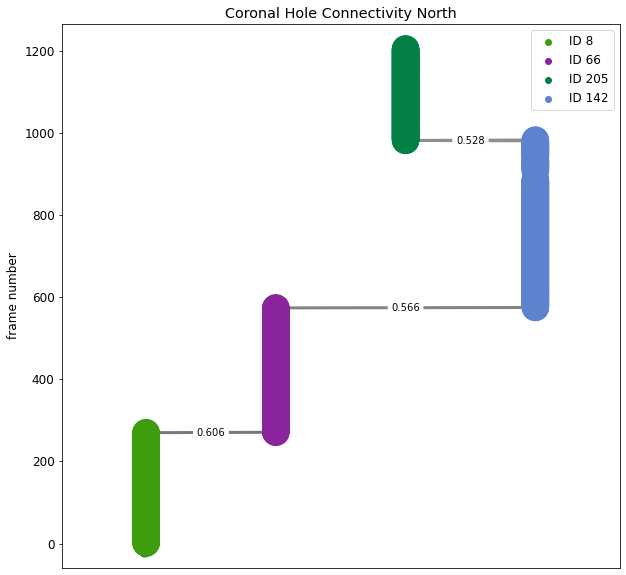

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
# draw graph, nodes positions are based on their count and frame_num.
# labels are the coronal hole id number.
pos, labels = graph.get_plot_features(sub_graph=path_g)

edge_weights = nx.get_edge_attributes(G=path_g, name='weight')
edges, weights = zip(*edge_weights.items())

# plot nodes and labels.
nx.draw(path_g, pos=pos, font_weight='bold', ax=ax, node_size=700,
        node_color=[c.to_rgba(np.array(path_g.nodes[ch]["color"]) / 255)
                    for ch in path_g.nodes], edgelist=[])

#nx.draw_networkx_labels(G=path_g, pos=pos, labels=labels, ax=ax, font_size=8)
for ch in unique_id_class:
    ax.scatter([],[], c=[c.to_rgba(np.array(path_g.nodes[ch]["color"]) / 255)], label='ID {}'.format(path_g.nodes[ch]["id"]))

nx.draw_networkx_edges(path_g, pos=pos, edge_color=weights, edgelist=edges,
                                        edge_cmap=plt.cm.get_cmap('Greys'), edge_vmin=0,
                                        edge_vmax=1, width=3, ax=ax)

nx.draw_networkx_edge_labels(G=path_g, pos=pos, edge_labels=edge_weights, ax=ax, alpha=1, font_size=10)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.set_xlim(tuple(sum(i) for i in zip(ax.get_xlim(), (-0.5, 0.5))))

# set x and y axis ticks to be integers
ax.yaxis.get_major_locator().set_params(integer=True)
ax.xaxis.get_major_locator().set_params(integer=True)

ax.axis('on')
ax.set_ylabel("frame number")
_ = ax.set_title("Coronal Hole Connectivity North")
_ = plt.gca().legend()

plt.savefig('figures/north_ch_shortest_path_res_8_to_205.png')

# Spatiotemporal Analysis of the North pole

In [25]:
frame_array = np.arange(1, 1205)

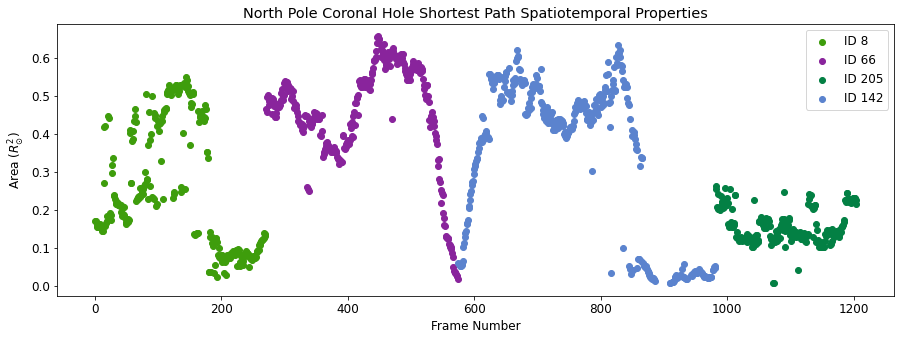

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))


for frame in frame_array:
    holder = []
    for node in path_g:
        if path_g.nodes[node]["frame_num"] == frame:
            holder.append(node)
            
    area = 0 
    for node in holder:
        area += path_g.nodes[node]["area"]
    
    if area != 0:
        ax.scatter(frame, area, c=[c.to_rgba(np.array(path_g.nodes[holder[0]]["color"]) / 255)])
        
for ch in unique_id_class:
    ax.scatter([],[], c=[c.to_rgba(np.array(path_g.nodes[ch]["color"]) / 255)], label='ID {}'.format(path_g.nodes[ch]["id"]))

        
_ = ax.set_xlabel("Frame Number")
_ = ax.set_ylabel("Area ($R_{\odot}^2$)")
_ = ax.set_title("North Pole Coronal Hole Shortest Path Spatiotemporal Properties")
_ = plt.legend()
plt.savefig('figures/north_ch_shortest_path_area.png')

# North Shortest Path and *Neighbors*

In [27]:
THRESH = 0.2

In [28]:
north_and_ne = path_g.copy()

In [29]:
# add all nodes that are adjacent to nodes in shortest path
for node in path_g:
    for adj_node in G[node]:
        # if the edge weight is greater than threshold, then add the neighbor node. 
        if G[node][adj_node]['weight'] >= THRESH:
            # check if the node already exists in shortest path
            if adj_node not in north_and_ne.nodes:
                # add the node.
                north_and_ne.add_node(str(adj_node), 
                            area=G.nodes[adj_node]["area"],
                            id=G.nodes[adj_node]["id"],
                            frame_num=G.nodes[adj_node]["frame_num"],
                            frame_timestamp=G.nodes[adj_node]["frame_timestamp"],
                            count=G.nodes[adj_node]["count"],
                            color=G.nodes[adj_node]["color"])

In [30]:
for u,v,w in G.edges.data():
    # if the two nodes exist in the shorstest path and neighbors then add the edge. 
    if u in north_and_ne and v in north_and_ne:
        if not north_and_ne.has_edge(u, v):
            north_and_ne.add_edge(u, v, weight=w)

In [31]:
ne_classes = set()

for node in north_and_ne:
    ne_classes.add(G.nodes[node]["id"])

In [32]:
str(ne_classes)

'{3, 132, 5, 134, 7, 8, 142, 143, 145, 146, 148, 154, 160, 34, 174, 176, 181, 182, 188, 192, 66, 194, 201, 205, 223, 225, 101, 230, 107, 235, 237, 246, 247, 123}'

no nodes in this frame 358
no nodes in this frame 620
no nodes in this frame 622
no nodes in this frame 887
no nodes in this frame 888
no nodes in this frame 889
no nodes in this frame 890
no nodes in this frame 891
no nodes in this frame 892
no nodes in this frame 893
no nodes in this frame 894
no nodes in this frame 895
no nodes in this frame 896
no nodes in this frame 897
no nodes in this frame 898
no nodes in this frame 899
no nodes in this frame 900
no nodes in this frame 901
no nodes in this frame 902
no nodes in this frame 903
no nodes in this frame 904
no nodes in this frame 905
no nodes in this frame 906
no nodes in this frame 907
no nodes in this frame 938
no nodes in this frame 939
no nodes in this frame 940
no nodes in this frame 941


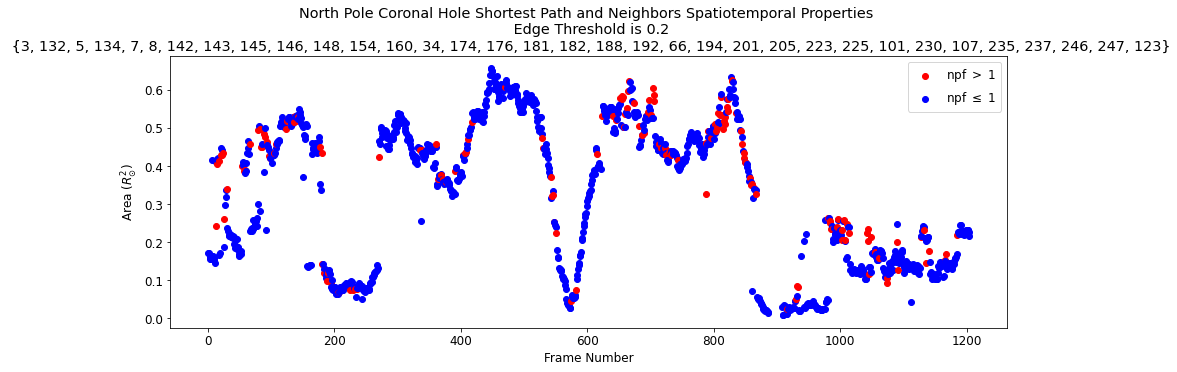

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))


for frame in frame_array:
    holder = []
    for node in north_and_ne:
        if north_and_ne.nodes[node]["frame_num"] == frame:
            holder.append(node)
            
    area = 0 
    for node in holder:
        area += north_and_ne.nodes[node]["area"]
        
    if len(holder) == 0:
        print("no nodes in this frame", frame)
    
    if area != 0:
        ax.scatter(frame, area, c=['r' if len(holder) > 1 else 'b'])

ax.scatter([], [], c="r", label="npf $>$ 1")
ax.scatter([], [], c="b", label="npf $\leq$ 1")

_ = ax.set_xlabel("Frame Number")
_ = ax.set_ylabel("Area ($R_{\odot}^2$)")
_ = ax.set_title("North Pole Coronal Hole Shortest Path and Neighbors Spatiotemporal Properties \n Edge Threshold is " + str(THRESH) + "\n " + str(ne_classes))
_ = plt.legend()
plt.savefig('figures/north_ch_shortest_path_and_ne_area' + str(THRESH) + '.png', bbox_inches='tight')

# Create Video 

In [60]:
dir_path = os.path.join(r"C:\Users\Opali\OneDrive\Desktop\CH_DB")


# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

video = cv2.VideoWriter(os.path.join(dir_path, "north_pole_" + str(THRESH) + ".mov"), fourcc, 1, (432, 288))


for frame in frame_array:
    
    holder = []
    
    for node in north_and_ne:
        if north_and_ne.nodes[node]["frame_num"] == frame:
            holder.append(node)
            
    else:
        timestamp = None
        for node in G:
            if G.nodes[node]["frame_num"] == frame:
                timestamp = G.nodes[node]["frame_timestamp"]
                break
        
        if timestamp is not None:
            pickle_file = str(timestamp).replace(':', '_') + ".pkl"
            frame_read = pickle.load(open(os.path.join(dir_path, "pkl", "pkl", pickle_file), "rb"))

            ch_list = frame_read.contour_list
            
            for ch in ch_list:
                ch_id = str(frame) + "_" + str(ch.id) + "_" + str(ch.count)
                if ch_id not in list(north_and_ne.nodes):
                    ch.color = (169,169,169)

            plot_coronal_hole(ch_list, 160, 400, "North Coronal Hole, Frame # " + str(frame), 
                              filename=os.path.join(dir_path, "frames_north.png"),
                              plot_rect=False, plot_circle=True, circle_radius=50, 
                              thickness_circle=1, thickness_rect=2, fontscale=0.3, 
                              origin=None)
            
            
            image_file_name = os.path.join(dir_path, "frames_north.png")
            img = cv2.imread(image_file_name)
            video.write(img)

cv2.destroyAllWindows()
video.release()

# Similar Analysis for the South Pole

In [34]:
for node in G.nodes:
    if G.nodes[node]["id"] == 2 and G.nodes[node]["frame_num"] == 1205:
        print(G.nodes[node])
        print(node)
        
    if G.nodes[node]["id"] == 2 and G.nodes[node]["frame_num"] == 1:
        print(G.nodes[node])
        print(node)

{'area': 0.8518956, 'id': 2, 'frame_num': 1, 'frame_timestamp': Timestamp('2010-12-29 02:00:47'), 'count': 0, 'color': [3, 191, 64], 'x-pos': 0}
1_2_0
{'area': 0.7601107, 'id': 2, 'frame_num': 1205, 'frame_timestamp': Timestamp('2011-04-08 10:00:38'), 'count': 0, 'color': [3, 191, 64], 'x-pos': 0}
1205_2_0


In [35]:
start = "1_2_0"
end = "1205_2_0"

In [36]:
path2 = nx.algorithms.shortest_paths.weighted.dijkstra_path(DiG, source=start, target=end, weight=func)

In [37]:
set_of_classes_south = set()

In [38]:
for node in path2:
    #print(str(node) + ", id: " + str(G.nodes[node]["id"]) + ", frame: "+ str(G.nodes[node]["frame_num"]) )
    set_of_classes_south.add(G.nodes[node]["id"])

In [39]:
set_of_classes_south

{2, 252}

In [40]:
path_g_south = G.subgraph(path2)

In [41]:
unique_id_class_2 = []

In [42]:
for id_class in list(set_of_classes_south):
    for node in path_g_south.nodes:
        if path_g_south.nodes[node]["id"] == id_class:
            unique_id_class_2.append(node)
            break

In [43]:
unique_id_class_2

['645_2_0', '1183_252_0']

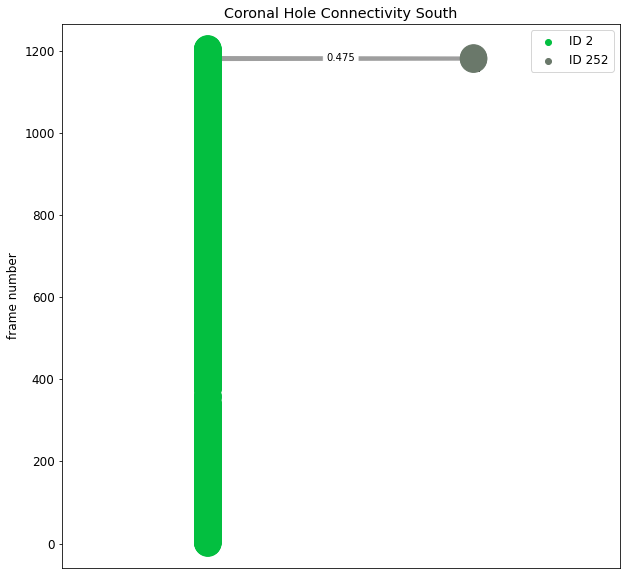

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
# draw graph, nodes positions are based on their count and frame_num.
# labels are the coronal hole id number.
pos, labels = graph.get_plot_features(sub_graph=path_g_south)

edge_weights = nx.get_edge_attributes(G=path_g_south, name='weight')
edges, weights = zip(*edge_weights.items())

# plot nodes and labels.
nx.draw(path_g_south, pos=pos, font_weight='bold', ax=ax, node_size=700,
        node_color=[c.to_rgba(np.array(path_g_south.nodes[ch]["color"]) / 255)
                    for ch in path_g_south.nodes], edgelist=[])

#nx.draw_networkx_labels(G=path_g, pos=pos, labels=labels, ax=ax, font_size=8)
for ch in unique_id_class_2:
    ax.scatter([],[], c=[c.to_rgba(np.array(path_g_south.nodes[ch]["color"]) / 255)], label='ID {}'.format(path_g_south.nodes[ch]["id"]))

nx.draw_networkx_edges(path_g_south, pos=pos, edge_color=weights, edgelist=edges,
                                        edge_cmap=plt.cm.get_cmap('Greys'), edge_vmin=0,
                                        edge_vmax=1, width=3, ax=ax)

nx.draw_networkx_edge_labels(G=path_g_south, pos=pos, edge_labels=edge_weights, ax=ax, alpha=1, font_size=10)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.set_xlim(tuple(sum(i) for i in zip(ax.get_xlim(), (-0.5, 0.5))))

# set x and y axis ticks to be integers
ax.yaxis.get_major_locator().set_params(integer=True)
ax.xaxis.get_major_locator().set_params(integer=True)

ax.axis('on')
ax.set_ylabel("frame number")
_ = ax.set_title("Coronal Hole Connectivity South")
_ = plt.gca().legend()

plt.savefig('figures/south_ch_shortest_path_res_2_to_2.png')

### Note: If we want to include more nodes, we can analyze all the adjacent nodes in this path that have an edge weight greater than a certain thresh. 

# Spatiotemporal Analysis of the South Pole

In [45]:
set_of_classes_south

{2, 252}

no nodes in this frame 187
no nodes in this frame 189
no nodes in this frame 343
no nodes in this frame 344
no nodes in this frame 345
no nodes in this frame 346
no nodes in this frame 347
no nodes in this frame 348
no nodes in this frame 349
no nodes in this frame 350
no nodes in this frame 351
no nodes in this frame 352
no nodes in this frame 353
no nodes in this frame 354
no nodes in this frame 355
no nodes in this frame 360
no nodes in this frame 361
no nodes in this frame 362
no nodes in this frame 363
no nodes in this frame 364
no nodes in this frame 365
no nodes in this frame 366
no nodes in this frame 367
no nodes in this frame 368
no nodes in this frame 369
no nodes in this frame 370
no nodes in this frame 371
no nodes in this frame 372
no nodes in this frame 373
no nodes in this frame 374
no nodes in this frame 375
no nodes in this frame 1181
no nodes in this frame 1182


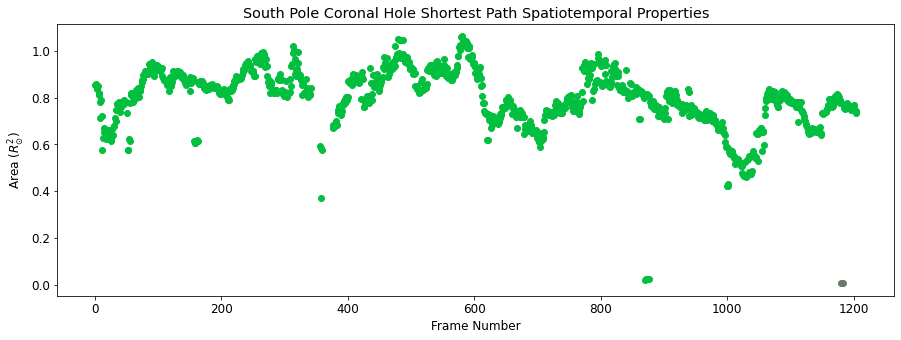

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))


for frame in frame_array:
    holder = []
    for node in path_g_south:
        if path_g_south.nodes[node]["frame_num"] == frame:
            holder.append(node)
            
    area = 0 
    for node in holder:
        area += path_g_south.nodes[node]["area"]
        
    if len(holder) == 0:
        print("no nodes in this frame", frame)
    
    if area != 0:
        ax.scatter(frame, area, c=[c.to_rgba(np.array(path_g_south.nodes[holder[0]]["color"]) / 255)])
        
for ch in unique_id_class_2:
    ax.scatter([],[], c=[c.to_rgba(np.array(path_g_south.nodes[ch]["color"]) / 255)], label='ID {}'.format(path_g_south.nodes[ch]["id"]))

_ = ax.set_xlabel("Frame Number")
_ = ax.set_ylabel("Area ($R_{\odot}^2$)")
_ = ax.set_title("South Pole Coronal Hole Shortest Path Spatiotemporal Properties")

plt.savefig('figures/south_ch_shortest_path_area.png')

# South Shortest Path and *Neighbors*

In [47]:
THRESH = 0.2

In [48]:
south_and_ne = path_g_south.copy()

In [49]:
# add all nodes that are adjacent to nodes in shortest path
for node in path_g_south:
    for adj_node in G[node]:
        # if the edge weight is greater than threshold, then add the neighbor node. 
        if G[node][adj_node]['weight'] >= THRESH:
            # check if the node already exists in shortest path
            if adj_node not in south_and_ne.nodes:
                # add the node.
                south_and_ne.add_node(str(adj_node), 
                            area=G.nodes[adj_node]["area"],
                            id=G.nodes[adj_node]["id"],
                            frame_num=G.nodes[adj_node]["frame_num"],
                            frame_timestamp=G.nodes[adj_node]["frame_timestamp"],
                            count=G.nodes[adj_node]["count"],
                            color=G.nodes[adj_node]["color"])

In [50]:
for u,v,w in G.edges.data():
    # if the two nodes exist in the shorstest path and neighbors then add the edge. 
    if u in south_and_ne and v in south_and_ne:
        if not south_and_ne.has_edge(u, v):
            south_and_ne.add_edge(u, v, weight=w)

In [51]:
ne_classes = set()

for node in south_and_ne:
    ne_classes.add(G.nodes[node]["id"])

In [52]:
str(ne_classes)

'{2, 16, 17, 147, 20, 21, 30, 37, 39, 173, 178, 180, 52, 183, 185, 58, 187, 193, 68, 70, 76, 212, 93, 226, 228, 103, 106, 241, 248, 251, 252, 126}'

no nodes in this frame 344
no nodes in this frame 345
no nodes in this frame 346
no nodes in this frame 347
no nodes in this frame 348
no nodes in this frame 349
no nodes in this frame 350
no nodes in this frame 351
no nodes in this frame 352
no nodes in this frame 353
no nodes in this frame 354
no nodes in this frame 361
no nodes in this frame 362
no nodes in this frame 363
no nodes in this frame 364
no nodes in this frame 365
no nodes in this frame 366
no nodes in this frame 367
no nodes in this frame 368
no nodes in this frame 369
no nodes in this frame 370
no nodes in this frame 371
no nodes in this frame 372
no nodes in this frame 373
no nodes in this frame 374
no nodes in this frame 1181


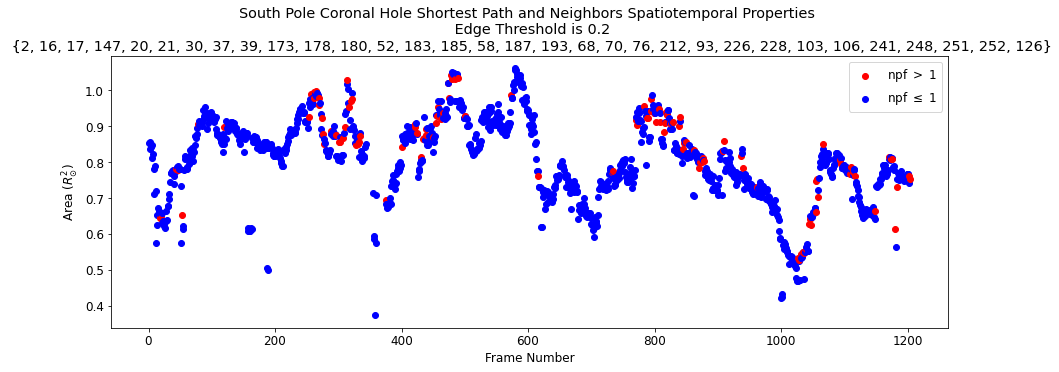

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))


for frame in frame_array:
    holder = []
    for node in south_and_ne:
        if south_and_ne.nodes[node]["frame_num"] == frame:
            holder.append(node)
            
    area = 0 
    for node in holder:
        area += south_and_ne.nodes[node]["area"]
    
    if len(holder) == 0:
        print("no nodes in this frame", frame)
    
    if area != 0:
        ax.scatter(frame, area, c=['r' if len(holder) > 1 else 'b'])

ax.scatter([], [], c="r", label="npf $>$ 1")
ax.scatter([], [], c="b", label="npf $\leq$ 1")

_ = ax.set_xlabel("Frame Number")
_ = ax.set_ylabel("Area ($R_{\odot}^2$)")
_ = ax.set_title("South Pole Coronal Hole Shortest Path and Neighbors Spatiotemporal Properties \n Edge Threshold is " + str(THRESH) + "\n " + str(ne_classes))
_ = plt.legend()
plt.savefig('figures/south_ch_shortest_path_and_ne_area' + str(THRESH) + '.png', bbox_inches='tight')

# Create Video 

In [54]:
dir_path = os.path.join(r"C:\Users\Opali\OneDrive\Desktop\CH_DB")

In [59]:
# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

video = cv2.VideoWriter(os.path.join(dir_path, "south_pole_" + str(THRESH) + ".mov"), fourcc, 1, (432, 288))


for frame in frame_array:
    
    holder = []
    
    for node in south_and_ne:
        if south_and_ne.nodes[node]["frame_num"] == frame:
            holder.append(node)
            
    else:
        timestamp = None
        for node in G:
            if G.nodes[node]["frame_num"] == frame:
                timestamp = G.nodes[node]["frame_timestamp"]
                break
        
        if timestamp is not None:
            pickle_file = str(timestamp).replace(':', '_') + ".pkl"
            frame_read = pickle.load(open(os.path.join(dir_path, "pkl", "pkl", pickle_file), "rb"))

            ch_list = frame_read.contour_list
            
            for ch in ch_list:
                ch_id = str(frame) + "_" + str(ch.id) + "_" + str(ch.count)
                if ch_id not in list(south_and_ne.nodes):
                    ch.color = (169,169,169)

            plot_coronal_hole(ch_list, 160, 400, "South Coronal Hole, Frame # " + str(frame), 
                              filename=os.path.join(dir_path, "frames_south.png"),
                              plot_rect=False, plot_circle=True, circle_radius=50, 
                              thickness_circle=1, thickness_rect=2, fontscale=0.3, 
                              origin=None)
            
            
            image_file_name = os.path.join(dir_path, "frames_south.png")
            img = cv2.imread(image_file_name)
            video.write(img)

cv2.destroyAllWindows()
video.release()